In [42]:
# Import libraries
import sys
import os
import json 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import h5py
from jupyterlab_h5web import H5Web

In [43]:
from compositionspace.datautils import DataPreparation
from compositionspace.segmentation import CompositionClustering
from compositionspace.postprocessing import DataPostprocess

In [44]:
data = DataPreparation("experiment_params.yaml")
df_lst, files, ions, rrngs= data.get_apt_dataframe()
# print(f"{df_lst}, type {type(df_lst)}")
# print(files)
# print(ions)
# print(rrngs)

for idx, file in enumerate(files):
    org_file = df_lst[idx]
    atoms_spec = []
    c = np.unique(rrngs.comp.values)
    for i in range(len(c)):
        range_element = rrngs[rrngs['comp']=='{}'.format(c[i])]
        total, count = data.atom_filter(org_file, range_element)
        name = i
        total["spec"] = [name for j in range(len(total))]
        atoms_spec.append(total)
# print(atoms_spec)
df_atom_spec = pd.concat(atoms_spec)
# print(df_atom_spec)

Reading files:   0%|          | 0/4 [00:00<?, ?it/s]

## Load positions and iontypes from paraprobe-transcoder and paraprobe-ranger results

In [88]:
recon_fnm = "data/PARAPROBE.Transcoder.Results.SimID.636502001.nxs"
range_fnm = "data/PARAPROBE.Ranger.Results.SimID.636502001.nxs"

In [89]:
H5Web(recon_fnm)
# H5Web(range_fnm)

<jupyterlab_h5web.widget.H5Web object>

In [90]:
h5r = h5py.File(recon_fnm, "r")
trg = "/entry1/atom_probe/reconstruction/reconstructed_positions"
xyz = h5r[trg][:, :]
print(f"shape {np.shape(xyz)}, type {type(xyz)}, dtype {xyz.dtype}")

trg = "/entry1/atom_probe/ranging/peak_identification"
n_ion_types = len(h5r[trg])
iontypes = {}
for ion_id in np.arange(0, n_ion_types):
    iontypes[f"ion{ion_id}"] = (str(h5r[f"{trg}/ion{ion_id}/name"][:].astype(str)[0]), np.uint8(ion_id))
print(f"{n_ion_types}, iontypes {iontypes}")
h5r.close()

h5r = h5py.File(range_fnm, "r")
trg = "/entry1/process1/apply_existent_ranging"
ityp = h5r[f"{trg}/iontypes"][:]
print(f"shape {np.shape(ityp)}, type {type(ityp)}, dtype {ityp.dtype}")
h5r.close()

shape (4868202, 3), type <class 'numpy.ndarray'>, dtype float32
73, iontypes {'ion0': ('unknown iontype', 0), 'ion1': ('C ++', 1), 'ion2': ('C +', 2), 'ion3': ('O +', 3), 'ion4': ('Ti ++', 4), 'ion5': ('Ti ++', 5), 'ion6': ('Ti ++', 6), 'ion7': ('Ti ++', 7), 'ion8': ('Fe ++', 8), 'ion9': ('Fe +', 9), 'ion10': ('Fe ++', 10), 'ion11': ('Fe ++', 11), 'ion12': ('Fe ++', 12), 'ion13': ('Fe +', 13), 'ion14': ('Al ++', 14), 'ion15': ('Al +++', 15), 'ion16': ('Si ++', 16), 'ion17': ('Si ++', 17), 'ion18': ('Si ++', 18), 'ion19': ('Ti O ++', 19), 'ion20': ('Ti O ++', 20), 'ion21': ('Ti O ++', 21), 'ion22': ('Ti O ++', 22), 'ion23': ('Ti O ++', 23), 'ion24': ('Ti O +', 24), 'ion25': ('Ti O +', 25), 'ion26': ('Ti O +', 26), 'ion27': ('Ti O +', 27), 'ion28': ('Cr ++', 28), 'ion29': ('Cr ++', 29), 'ion30': ('Cr ++', 30), 'ion31': ('Cr +', 31), 'ion32': ('Cr +', 32), 'ion33': ('Mn ++', 33), 'ion34': ('Mn +', 34), 'ion35': ('Co ++', 35), 'ion36': ('Y +++', 36), 'ion37': ('Y ++', 37), 'ion38': ('Ga ++

In [40]:
def ceil_to_multiple(number, multiple):
    return multiple * np.ceil(number / multiple)

def floor_to_multiple(number, multiple):
    return multiple * np.floor(number / multiple)

# ceil to a multiple of 1.5
print(ceil_to_multiple(23.0000000000000000000000000000000000000, 1.5))
# floor to a multiple of 1.5
print(floor_to_multiple(-23.0000000000000000000000000000000000000, 1.5))

24.0
-24.0


## Voxelize with rectangular transfer function without creating slices

In [91]:
# print(type(df_lst))
column_names = ['x', 'y', 'z']
# initialize extent (number of cells) along x, y, z axes
extent = [0, 0, 0]
# initialize min, max bounds for x, y, z
aabb3d = np.reshape([np.finfo(np.float32).max, np.finfo(np.float32).min,
          np.finfo(np.float32).max, np.finfo(np.float32).min,
          np.finfo(np.float32).max, np.finfo(np.float32).min], (3, 2), order="C")
print(aabb3d)
n_ions = np.shape(xyz)[0]
voxel_identifier = np.asarray(np.zeros(n_ions), np.uint32)
print(f"shape {np.shape(voxel_identifier)}")
# edge length of cubic cells/voxels in nm
dedge = 2.0
for axis_id in [0, 1, 2]:
    column_name = column_names[axis_id]
    # i = np.asarray(df_lst[0].loc[:, column_name], np.float32)
    aabb3d[axis_id, 0] = floor_to_multiple(np.min((aabb3d[axis_id, 0], np.min(xyz[:, axis_id]))), dedge)
    aabb3d[axis_id, 1] = ceil_to_multiple(np.max((aabb3d[axis_id, 1], np.max(xyz[:, axis_id]))), dedge)
    extent[axis_id] = np.uint32((aabb3d[axis_id, 1] - aabb3d[axis_id, 0]) / dedge)
    print(aabb3d)
    print(extent)
    bins = np.linspace(1 * dedge, extent[axis_id] * dedge, num=extent[axis_id], endpoint=True)
    print(bins)
    if axis_id == 0:
        voxel_identifier = voxel_identifier + (np.asarray(np.digitize(xyz[:, axis_id], bins, right=True), np.uint32) * 1)
    elif axis_id == 1:
        voxel_identifier = voxel_identifier + (np.asarray(np.digitize(xyz[:, axis_id], bins, right=True), np.uint32) * np.uint32(extent[0]))
    else:
        voxel_identifier = voxel_identifier + (np.asarray(np.digitize(xyz[:, axis_id], bins, right=True), np.uint32) * np.uint32(extent[0] * extent[1]))
print(voxel_identifier[0:10])
print(np.max(voxel_identifier))

[[ 3.4028235e+38 -3.4028235e+38]
 [ 3.4028235e+38 -3.4028235e+38]
 [ 3.4028235e+38 -3.4028235e+38]]
shape (4868202,)
[[-3.2000000e+01  3.2000000e+01]
 [ 3.4028235e+38 -3.4028235e+38]
 [ 3.4028235e+38 -3.4028235e+38]]
[32, 0, 0]
[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64.]
[[-3.2000000e+01  3.2000000e+01]
 [-3.2000000e+01  3.2000000e+01]
 [ 3.4028235e+38 -3.4028235e+38]]
[32, 32, 0]
[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64.]
[[-32.  32.]
 [-32.  32.]
 [  0.  72.]]
[32, 32, 36]
[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68. 70. 72.]
[3072 3072 1189 1024   32    0 3072 1088 1252 3179]
36320


In [114]:
## Create a sorted lookup table for all ion positions (implicitly specified by their evaporation_id) O(n*log(n)) time-complexity operation wi

In [115]:
ion_struct = [('iontype', np.uint8), ('voxel_id', np.uint32), ('evap_id', np.uint32)]
lu_ityp_voxel_id_evap_id = np.zeros(n_ions, dtype=ion_struct)
lu_ityp_voxel_id_evap_id["iontype"] = ityp[:, 0]
del ityp
lu_ityp_voxel_id_evap_id["voxel_id"] = voxel_identifier
del voxel_identifier
lu_ityp_voxel_id_evap_id["evap_id"] = np.asarray(np.linspace(1, n_ions, num=n_ions, endpoint=True), np.uint32)
print(lu_ityp_voxel_id_evap_id[0:10])
lu_ityp_voxel_id_evap_id = np.sort(lu_ityp_voxel_id_evap_id, kind="stable", order=["iontype", "voxel_id", "evap_id"])
print(lu_ityp_voxel_id_evap_id[0:10])
print(lu_ityp_voxel_id_evap_id[-10::])

[( 8, 3072,  1) ( 8, 3072,  2) ( 8, 1189,  3) ( 8, 1024,  4)
 ( 8,   32,  5) ( 8,    0,  6) (29, 3072,  7) ( 8, 1088,  8)
 ( 8, 1252,  9) (29, 3179, 10)]
[(0, 0,   19) (0, 0,  120) (0, 0,  173) (0, 0,  219) (0, 0,  845)
 (0, 0,  856) (0, 0,  995) (0, 0, 1223) (0, 0, 1236) (0, 0, 1267)]
[(72, 30720, 4052165) (72, 31776, 4331875) (72, 31915, 4375588)
 (72, 32012, 4116453) (72, 32768, 4520185) (72, 32768, 4739678)
 (72, 33792, 4518381) (72, 33963, 4730446) (72, 34027, 4758833)
 (72, 34823, 4856367)]


In [116]:
## From this lookup we can very easily now compute the composition table

In [132]:
c = np.prod(extent)
# now just add weight/counts for a the iontype-specific part of the lookup-table
print(f"means we have to visit so that many entries in the lookup table {np.sum(lu_ityp_voxel_id_evap_id['iontype'] == 0)}")
print(f"but by virtue of construction of the lookup table all the indices will be close in cache")
total_weights = np.zeros(c, np.float64)
for ityp in np.arange(0, n_ion_types):
    inds = np.argwhere(lu_ityp_voxel_id_evap_id["iontype"] == ityp)
    offsets = (np.min(inds), np.max(inds))
    print(f"offsets {offsets}")
    # these are inclusive [min, max] array indices to use on lu_ityp_voxel_id_evap_id !
    
# alternatively one could make two loops where in the first an offset lookup table is generated
# after this point one can drop the iontype and evap_id columns from the lu_ityp_voxel_id_evap_id lookup table
    ityp_weights = np.zeros(c, np.float64)
    for offset in np.arange(offsets[0], offsets[1] + 1):
        ityp_weights[lu_ityp_voxel_id_evap_id["voxel_id"][offset]] += 1.
    print(f"ityp {ityp}, np.sum(ityp_weights) {np.sum(ityp_weights)}")
    total_weights += ityp_weights
    print(f"ityp {ityp}, np.sum(total_weights) {np.sum(total_weights)}")
print(f"cardinality of cg_grid {c}, n_ions {n_ions}")

# For a large number of voxels, say a few million and dozens of iontypes storing all
# ityp_weights in main memory might not be useful, instead these should be stored in the HDF5 file
# inside the loop and ones the loop is completed, i.e. each total weight for each voxel known
# we should update the data in the HDF5 file, alternatively one could also just store the
# weights instead of the compositions and then compute the composition with a linear in c*ityp time
# complex division, there are even more optimizations one could do, but probably using
# multithreading would be a good start before dwelling deeper already this code here is
# faster than the original one despite the fact that it works on the entire portland wang
# dataset with 4.868 mio ions, while the original test dataset includes only 1.75 mio ions
# the top part of the dataset also the code is much shorter to read and eventually even
# more robust wrt to how ions are binned with the rectangular transfer function
# one should say that this particular implementation (like the original) one needs
# substantial modification when one considers a delocalization kernel which spreads
# the weight of an ion into the neighboring voxels, this is what paraprobe-nanochem does
# one can easily imagine though that the results of this voxelization step can both be
# fed into the composition clustering step and here is then also the clear connection
# where the capabilities for e.g. the APAV open-source Python library end and Alaukik's
# ML/AI work really shines, in fact until now all code including the slicing could have
# equally been achieved with paraprobe-nanochem.
# Also the excessive reimplementation of file format I/O functions in datautils should
# be removed. There is an own Python library for just doing that more robustly and
# capable of handling all sorts of molecular ions and charge state analyses included

means we have to visit so that many entries in the lookup table 238176
but by virtue of construction of the lookup table all the indices will be close in cache
offsets (0, 238175)
ityp 0, np.sum(ityp_weights) 238176.0
ityp 0, np.sum(total_weights) 238176.0
offsets (238176, 238285)
ityp 1, np.sum(ityp_weights) 110.0
ityp 1, np.sum(total_weights) 238286.0
offsets (238286, 238570)
ityp 2, np.sum(ityp_weights) 285.0
ityp 2, np.sum(total_weights) 238571.0
offsets (238571, 241497)
ityp 3, np.sum(ityp_weights) 2927.0
ityp 3, np.sum(total_weights) 241498.0
offsets (241498, 243539)
ityp 4, np.sum(ityp_weights) 2042.0
ityp 4, np.sum(total_weights) 243540.0
offsets (243540, 245454)
ityp 5, np.sum(ityp_weights) 1915.0
ityp 5, np.sum(total_weights) 245455.0
offsets (245455, 264817)
ityp 6, np.sum(ityp_weights) 19363.0
ityp 6, np.sum(total_weights) 264818.0
offsets (264818, 266244)
ityp 7, np.sum(ityp_weights) 1427.0
ityp 7, np.sum(total_weights) 266245.0
offsets (266245, 3816575)
ityp 8, np.sum(ity

In [17]:
data.get_big_slices()
print(data.chunk_files)

Reading files:   0%|          | 0/2 [00:00<?, ?it/s]

Creating chunks:   0%|          | 0/10 [00:00<?, ?it/s]

['output/file_R31_06365-v02_pos_large_chunks_arr.h5']


I am convinced that chunking in principle is useful to not have all the data in memory, but this implementation does not care about this.<br>
Honestly, I would remove this idea of chunking, all what is happening here is apply an iontype label and split the dataset into chunks<br>
the labeling is an O(n) operation, chunking is O(1). Also way to much file overhead and no distinction between charge states...<br>
I would recommend starting with the output from a paraprobe-transcoder, paraprobe-ranger run which already uses NeXus, recovers<br>
charge states and distinguishes them directly.<br>

Action points:
* Run paraprobe-transcoder on the recon/range file
* Run paraprobe-ranger for the entire dataset

In [19]:
data.get_voxels()
print(data.voxel_files)

Getting Voxels:   0%|          | 0/10 [00:00<?, ?it/s]

['output/file_R31_06365-v02_pos_small_chunks_arr.h5']


The voxelization results in a data structure that is effectively abusing the HDF5 library because unnecessarily groups are created<br>
Maybe for the purpose to get quickly which ions are in which voxel but honestly masked operations on numpy arrays<br>
would allow one to filter this in a fraction of the time. Also no delocalization is computed.<br>
A simple call to paraprobe-nanochem using the rectangular transfer function as a delocalization kernel would yield you the same result.<br>

Action points:
* Refactor the voxelization to yield one array of the voxel id.

In [ ]:
data.calculate_voxel_composition()
print(data.voxel_ratio_file)

But there is a key difference to paraprobe: Namely, the computation of the composition for each iontype in each voxel<br>
while in paraprobe one has to a priori select for which iontype combination to compute the voxel composition<br>

In [4]:
data.chunk_files

['output/file_R31_06365-v02_pos_large_chunks_arr.h5']

In [5]:
data.voxel_files

['output/file_R31_06365-v02_pos_small_chunks_arr.h5']

In [6]:
data.voxel_ratio_file

'output/output_vox_ratio_composition.h5'

In [3]:
h5w = h5py.File("apm.composition.space.nxs", "w")
trg = "/entry1"
# header section
grp = h5w.create_group("/entry1")
NX_APPDEF_VERSION = "nexus-fairmat-proposal successor of 9636feecb79bb32b828b1a9804269573256d7696"
NX_APPDEF_NAME = "NXapm_composition_space"
grp.attrs["version"] = NX_APPDEF_VERSION
grp.attrs["NX_class"] = "NXentry"
dst = h5w.create_dataset(f"{trg}/definition", data=NX_APPDEF_NAME)

# voxelization
trg = "/entry1/voxelization"
grp = h5w.create_group(f"{trg}")
grp.attrs["NX_class"] = "NXprocess"
dst = h5w.create_dataset(f"{trg}/sequence_index", data=np.uint64(1))
trg = "/entry1/voxelization/cg_grid"
grp = h5w.create_group(f"{trg}")
grp.attrs["NX_class"] = "NXcg_grid"
dst = h5w.create_dataset(f"{trg}/dimensionality", data=np.uint64(3))
dst = h5w.create_dataset(f"{trg}/cardinality", data=np.uint64(8846))
# dst = h5w.create_dataset(f"{trg}/origin", data=###)
dst = h5w.create_dataset(f"{trg}/symmetry", data="cubic")
dst = h5w.create_dataset(f"{trg}/cell_dimensions", data=np.asarray([2., 2., 2.], np.float64))
dst.attrs["unit"] = "nm"
dst = h5w.create_dataset(f"{trg}/extent", data=np.asarray([1, 2, 3], np.uint32))  # max. 2*32 cells
dst = h5w.create_dataset(f"{trg}/identifier_offset", data=np.uint64(0))  # start counting cells from 0
# dst = h5w.create_dataset(f"{trg}/position", compression="gzip", compression_level=1, data=###)
# dst.attrs["unit"] = "nm"
# dst = h5w.create_dataset(f"{trg}/coordinate", compression="gzip", compression_level=1, data=###)
# dst = h5w.create_dataset(f"{trg}/voxel_identifier", compression="gzip", compression_level=1, data=###)

# total atom/molecular ion contribution/intensity/count in each voxel/cell
# grp = h5w.create_dataset(f"{trg}/total", compression="gzip", compression_level=1, data=###)
# grp.attrs["unit"] = "a.u."

# atom/molecular ion-type-specific contribution/intensity/count in each voxel/cell
ion_id = 1
for idx in ions:
    trg = "/entry1/voxelization/ion{ion_id}"
    grp = h5w.create_group(f"{trg}")
    grp.attrs["NX_class"] = "NXion"
    # dst = h5w.create_dataset(f"{trg}/name", data=###)
    dst = h5w.create_dataset(f"{trg}/weight", compression="gzip", compression_level=1, data=###)
    dst.attrs["unit"] = "a.u."
    dst = h5w.create_dataset(f"{trg}/composition", compression="gzip", compression_level=1, data=###)
    dst.attrs["unit"] = "a.u."
    ion_id += 1

h5w.close()

8846
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 'Total_no', 'vox']


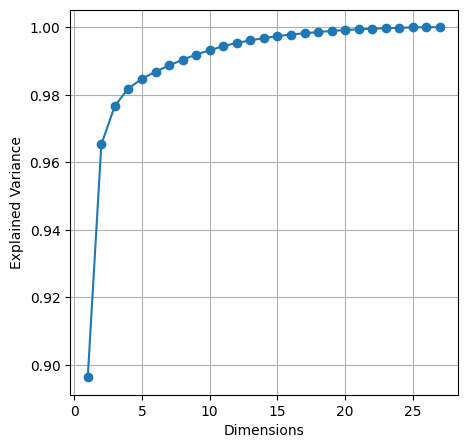

In [7]:
comps = CompositionClustering("experiment_params.yaml")
res = comps.get_PCA_cumsum(data.voxel_ratio_file, data.voxel_files[0])

In [25]:
with h5py.File(data.voxel_files[0],"r") as hdf:
    group = hdf.get("Group_sm_vox_xyz_Da_spec")
    group0 = hdf.get("0")
    spec_lst = list(list(group0.attrs.values())[1])
    print(f"value {spec_lst}, type {type(spec_lst)}, len {len(spec_lst)}")

value ['Al:1', 'Al:1 O:1', 'As:1', 'B:1', 'C:1', 'Co:1', 'Cr:1', 'Cr:1 O:1', 'Fe:1', 'Fe:1 H:1', 'Fe:1 O:1', 'Ga:1', 'H:2 O:1', 'Mn:1', 'Mo:1', 'Ni:1', 'O:1', 'O:1 H:1', 'Si:1', 'Si:1 O:1', 'Ti:1', 'Ti:1 C:1', 'Ti:1 O:1', 'Ti:1 O:2', 'V:1', 'Y:1', 'Y:1 O:1'], type <class 'list'>, len 27


Clustering:   0%|          | 0/9 [00:00<?, ?it/s]

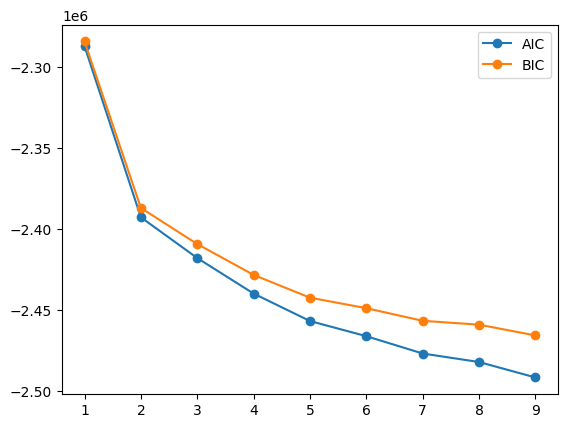

In [8]:
res = comps.get_bics_minimization(data.voxel_ratio_file, data.voxel_files[0])

In [9]:
comps.get_composition_clusters(data.voxel_ratio_file, data.voxel_files[0])

In [10]:
comps.generate_plots()

In [11]:
pdata = DataPostprocess("experiment_params.yaml")

  0%|          | 0/31 [00:00<?, ?it/s]

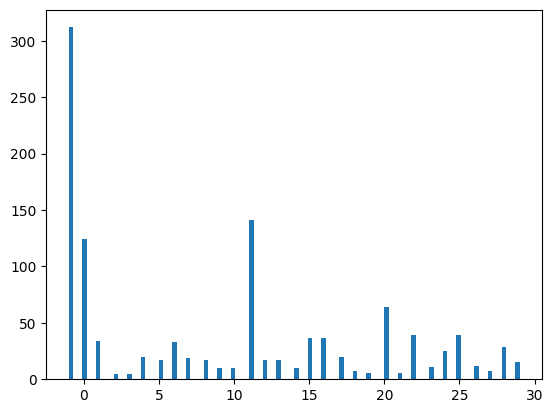

In [12]:
pdata.DBSCAN_clustering(comps.voxel_centroid_output_file, cluster_id = 0,
                        plot=True, plot3d=True, save=True)